# Working with linear regressions in Python

In experiment 1, you say a short version of this, where we plotted some data and got the equation of a line! However, we'd like to be able to do some more sophisticated data analysis when working with linear regressions. Today we're going to work with some sample data and take a look at how to think seriously about error in a real experiment!

We have sample data collected for the following known concentrations, over three trials:
0.00 mM, 9.36 mM, 18.72 mM, 28.08 mM, 37.44 mM, 44.54 mM

Trial 1: 0.000, 0.092, 0.182, 0.243, 0.325, 0.410
 
Trial 2: 0.000, 0.081, 0.177, 0.249, 0.37,  0.383
 
Trial 3: 0.000, 0.088, 0.169, 0.233, 0.310, 0.396

This data is saved in a file called "drylabdata.csv" Be sure you have that file downloaded onto your computer!
  
We also measured an unknown solution which produced the following absorbance values:

* 0.273
* 0.270
* 0.269
        
      
Think about what you need to do to turn this data into a useful calibration curve to determine the concentration of the unknown. In words, write out a plan for everything you need to do here (note, how are you going to handle the fact that we have multiple measurements for each standard solution?)









After you have brainstormed a plan, move on to the code:

In [3]:
# we will often import a number of extra packages into python. These are just a the ones we need today:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


# The first thing you're likely to need is to turn all of those replicate values into averages, and compile those averages into a single array
data = np.genfromtxt('drylabdata.csv', dtype=float, delimiter=',', names=None) 

print(data)

# Note the format here; each row is a trial, each column is a different data set. 

[[0.    0.092 0.182 0.243 0.325 0.41 ]
 [0.    0.081 0.177 0.249 0.37  0.383]
 [0.    0.088 0.169 0.233 0.31  0.396]]


## Plotting a standard curve when replicate data was collected

Hopefully you realized that you probably need to take the average of the three trials here before you combine all of your data!

This is something you've done before, but to avoid having to type everything out six times to cover all of our trials, we're going to automate this process with a for loop!

We might also want to have some idea about the precision of those values. Run this code once without any changes and think about how it's working! Then, add new code inside the for loop to produce a second array which has the standard deviations in it for each set of standards

In [9]:
# take the average of the blank, so we can subtract it from each data point
blank_mean = np.mean(data[:,0])
print(blank_mean)

absorbance = []
std =[]
columns = data.shape[1]

for x in range(columns):
    # here we calculate the average of each column. 
    
    average = np.mean(data[:,x])
    absorbance.append (average)
    
    #calculate the standard deviation of each column
    std_temp = np.std(data[:,x]) 
    std.append (std_temp)
    
    
    
# here i'm just converting standard deviation into a numpy array to make our lives easier later
# the append command as we use it here only works on regular lists, not numpy arrays, which is something to be aware of.
std = np.array(std)  

# but numpy arrays are way easier to do simple math with; say to 'correct' all of our absorbance values by subtracting the blank!
absorbance = np.array(absorbance) -  blank_mean



# take a look at your reported values
print(absorbance)
print (std)

0.0
[0.         0.087      0.176      0.24166667 0.335      0.39633333]
[0.         0.00454606 0.00535413 0.00659966 0.0254951  0.01102522]


Text(0, 0.5, 'happiness (are there units here too?)')

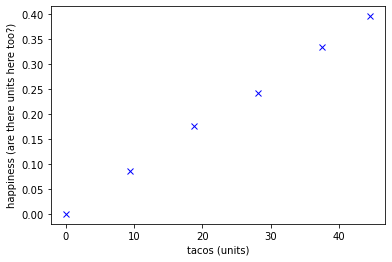

In [10]:
# We also need the concentration values which correspond to our data, to use as our x-axis values.
# For now, we can record them directly from the data
concentration = np.array([0, 9.36, 18.72, 28.08, 37.44, 44.54]) #mM 


# put together a graph using the plot command
# in 'plot', first comes the x axis, then the y, then 'ro' plots our points as red circles. 



plt.plot(concentration, absorbance, 'bx')

# Add reasonable labels on the x and y axis, always including units.
plt.xlabel("tacos (units)")
plt.ylabel("happiness (are there units here too?)")



Now you should see a figure above with red dots making the data points, along with some very unhelful axis labels. Update the axis labels to something that is actually properly descriptive for this data, and then rerun this code now that you have updated it.


## Adding error bars to our plot

We might consider using the standard deviation as a way to communicate some uncertainty in each of these values. We can do that by adding error bars to the plot!

Standard deviation is a very blunt instrument for expressing error in this case, but it is better than nothing. Let's try that first.

Text(0, 0.5, 'average absorbance')

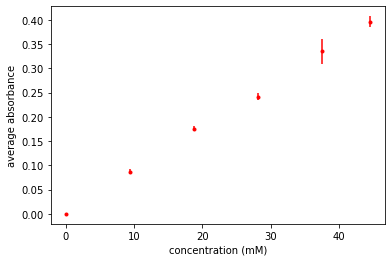

In [11]:
plt.errorbar(concentration, absorbance, yerr = std, xerr = None, fmt = 'r.')
plt.xlabel("concentration (mM)")
plt.ylabel("average absorbance")

#plt.savefig("my first python graph_with error bars.png")

 It is best to use the confidence interval for error bars instead! Remember, we just need to multiple our standard deviation by a Student's t constant, and divide by the square root of n. Here, let's show error bars at the 95 % confidence interval

Text(0, 0.5, 'average absorbance')

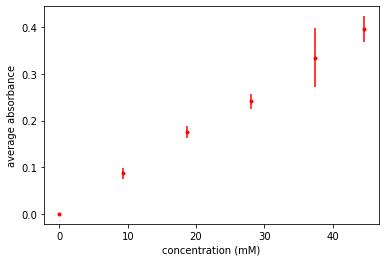

In [12]:

# use c to set the confidence you want (90 % is 0.90, for example)
c = 0.95
alpha = 1-c
# have you seen any command that might give you n without just inputting a number? To make your code more general for different data sets?
n = 3

t = stats.t.ppf(1-alpha/2, n-1)

CI_95 = std*(t/math.sqrt(n))

plt.errorbar(concentration, absorbance, yerr = CI_95, xerr = None, fmt = 'r.')
plt.xlabel("concentration (mM)")
plt.ylabel("average absorbance")

#fig.savefig("CI95_errorbars.png")

## External Calibration Curve
This type of plot is called an <b> external calibration curve </b> in analytical chemistry, because we can take some other (external) data point, for which we have, say, a density measurement, and use this plot to determine that unknown sample's concentration. You have seen this before in general chemistry (for example, you have plotted absorbance vs. concentration Ni in 152L)


To get the most out of an external calibration curve, it's helpful to have the equation of the line, in <i> y = mx + b </i> format. That allows you to quickly and easily do the math to determine any <i> x </i> (here, concentration in mole/liter) for any measured <i> y </i> (here, density). You may know how to do this in Excel, or on your graphing calculator. Let's take a look at how it works in Python!

In [13]:
# the linear regression function in the scipy stats module returns 5 values: slope, intercept, R-squared and then two uncertainty values p and s_m
# we'll ignore the last two for the moment, since all we really need right now is the equation of the line
m, b, R2, p, s_m = stats.linregress(concentration, absorbance)

print (F'the equation of the line is y = {m}x + {b} and its R-squared value is {R2}')




the equation of the line is y = 0.008824245297230318x + 0.002836459106767386 and its R-squared value is 0.9992935841235739


## Adding the 'best fit line' to your graph

It's always a nice reality check to see the line plotted along with your data. In this case, we can think about this line as a model to help us make a prediction about our data. So we can plug in a range of concentration values, and we so we can plot the y values that our y = mx + b model predicts, and see how well it matches the real data.

Text(0, 0.5, 'average absorbance')

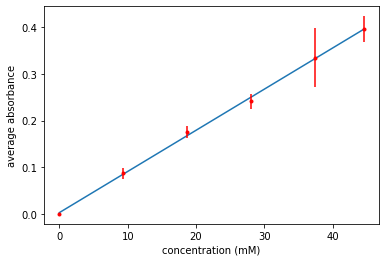

In [14]:
# Use our predicted model
predict_y = (concentration*m)+b
# Plot the predicted data (note if we don't ask for a specific marker style, we'll just get a line)
plt.plot(concentration,predict_y)

#add the real data to the plot, just like we did before:
plt.errorbar(concentration, absorbance, yerr = CI_95, xerr = None, fmt = 'r.')
plt.xlabel("concentration (mM)")
plt.ylabel("average absorbance")



## Solve for your unknown

Using the equation above, calculate your unknown concentration by hand first. Then complete the code below to calculate the unknown concentration. Make sure your hand-written calculation and your python code are producing the same result!

In [15]:
#Add the absorbance of your unknown here:

unknown = np.array([0.273,0.270,0.269])

unknown_av = np.mean(unknown)

unknown_std = np.std(unknown)

# now using m, b and unknown_density, solve for unknown_concentration
unknown_concentration = (unknown_av-b)/m

print ('the concentration of the unknown is ' + str(unknown_concentration) + ' mM')

#do your values match? If not, check your math!

the concentration of the unknown is 30.351627650691402 mM


## Uncertainty in a linear regression

We have an $R^{2}$ value which gives us an idea how well our predicted line is able to fit our real data, but it's hard to turn that value into a real uncertainty value on our unknown calcultion. Ideally, we'd like an uncertainty in the same units are our final answer here (so in this case, in mM). In order to do that, we need to think about what error actually means in a linear regression.

You read a lot of detail about how the matrix math works to produce that linear regression, and along with it, error values in the slope and intercept values produced. For whatever reason, most of the python linear regression packages just return the error in the slope. This is useful if you're main goal is to use a linear regression to determine a relationship between your variables, but in our case, we really need the error in the y values being predicted. That is the value we can transform into an x value error!

Think about what error on the y-value means. You're making a prediction, so our questions is how close is that prediction to the real value?

First, we'll think about the deviation of each measured y value ($y_{i}$) from the predicted y value (where $ y= mx+b $):

$$ d_{i} = y_{i} - (m x_{i} + b) $$

Then we want to compile those deviations for every point we have available, to turn them into an overall assessment of the standard deviation of the y values:

$$ s_{y}={\sqrt {\frac {\sum (d_{i})^{2}}{n-2}}} $$

In [16]:
# Manually calculate error in y 
# standard error in most python packages is the error in the slope, rather than error in the y-predicitions of the model


sum_square = 0

n = len(absorbance)

## so here, for every single point in our array, we're plugging in concentration, and comparing it to the actual measured absorbance
# Again, note that our count variable does double duty; keeping track of the while loop, and calling the right array value! 

for x in range(n):
    sum_square = sum_square + ((absorbance[x]-(m*concentration[x])-b)**2)
    
    
y_err = math.sqrt(sum_square/(n-2))
print (F"the y error predicted by this linear regression model is {y_err} arbirtrary absorbance units")


the y error predicted by this linear regression model is 0.006278304548066312 arbirtrary absorbance units


### Standard error in the intercept

Since the linear regression command in the stats module gives us the uncertainty in the slope, and we just calculated the uncertainty in the y values, we can take a shortcut to the uncertainty in the intercept, which avoids having to actually do any matrix math here. Note that

$$ u_{m}^{2} = \frac{s_{y}^{2}n}{D} $$

Can be rewritten as $$ D = \frac{s_{y}^{2}n}{u_{m}^{2}} $$

So that we can write $ u_{b}^{2} $ in terms of values we have already calculated!
$$ u_{b}^{2} = \frac{s_{y}^{2}\sum{x_{i}^{2}}}{D} = \frac{\sum{x_{i}^{2}}u_{m}^{2}}{n} $$

Once you have all of these uncertainty values, be sure to print out equation of the line, with full uncertainty and correct sig figs!


In [24]:
s_b = math.sqrt((sum(concentration**2)*(s_m**2))/(len(concentration)))

print(F'error in the slope is {s_m}')
print(F"error in the intercept is {s_b}")

#print the full equation of the line, with correct sig figs here (i.e y +/- yerror = etc. etc.)

error in the slope is 0.00016592926491514943
error in the intercept is 0.004600411736733409


### Convert a y value into an uncertainty on our calculated x value

Now we have all of the information we need to propogate error through the calibration curve. The equation needed is shown below:

$$ s_{x}= \frac{s_{y}}{\mid{m}\mid}{\sqrt {\frac {1}{k} + \frac {1}{n} + \frac {(y-\bar{y})^{2}}{m^{2}\sum (x-\bar{x})^{2}}}} $$

You now have all of these variables:  m is the slope, k is the number of replicate measurements in your unknown, n is the number of points in your calibration curve, and x is all of your calibration curve x values, either individually ($ x_{i} $) or the average of those values $ (\bar{x} ) $ 

$\bar{y}$ is the average of all of the y values in your calibration curve, and y is the unknown you measured. Note that this means that the closer your measured unknown is to the center of your calibration curve, the smaller that value will be!

Now we have to set up some math to make this happen. I'd strongly suggest breaking it down into components!

In [17]:
# first, s_y/m

var1 = y_err/m

# then, lets get all of the pieces inside the square root

# here we're using the length command to just check how long our unknown array was, and how long our calibration curve x value array was
inv_k = 1/len(unknown)
inv_n = 1/len(concentration)

# now let's get the two averages
y_bar = np.mean(absorbance)
x_bar = np.mean(concentration)

# We'll need a loop to handle the sum

# ss is where we'll save the sum of squares

ss = 0

# you'll need a fpr loop to compute the sum, like you've seen before
# Can you complete the for loop? 
for x in range(len(unknown)):
    ss = 
    


# now calculate the whole last component

var4 = ((unknown_av-y_bar)**2)/((m**2)*ss)



s_x =  var1*math.sqrt(inv_k+inv_n+var4)

# always report uncertainy values with their accompanying measured values
print (F'the concentration of the unknown is ' + str(unknown_concentration) + ' mM +/- ' + str(s_x) + 'mM')

#report a relative error instead of absolute

s_x_rel = (s_x/unknown_concentration) * 100

print ('the concentration of the unknown is ' + str(unknown_concentration) + ' mM +/- ' + str(s_x_rel) + '%')

SyntaxError: invalid syntax (395123253.py, line 24)

## Conclusion

You should now have working code for several key things:
1. Graphing external calibration data correctly - including descriptive axis labels, line of best fit and error bars
2. Linear regression - determination of the line of best fit, along with detailed error analysis (R squared values, as well as error on all variables involved in the linear regression. A linear regression is NOT complete without error in slope, intercept and y predictions.
3. Solving for unknown concentrations with appropraite error. You now should be able to report a final measured value with a reasonable error on that x value. Be sure to think carefully about what these numbers mean!

Make sure this code is working and that you understand which parts are doing what. Submit this code for today's dry lab, and start working to adapt this code for use with your ICP-OES data!
